# **Data Cleaning and Feature Engineering**

## Objectives

1. Clean dataset
2. Engineer new features
3. Transform features in preparation for ML modelling

## Inputs

- acled_original_optimised.csv file

## Outputs

1. Cleaned data set
2. ML modelling-ready input data set (with Feature Engineering)

## Additional Comments

<ins>Cleaning list from EDA notebook</ins>

1. actor2, inter2, population_1km, population_best, deal with missing values
2. disorder_type, has only 1 value type, drop
3. Consider dropping:
    - actor1/actor2 (name of beligerent), many unique values, difficult to interpret
3. interaction, check if column value can be grouped together
4. source, try to recategorise values, too many in current state
5. source_scale, try to recategorise values, note category 'Other'
6. Create additional dataset for DBSCAN without geo_precision = 3



In [81]:
# import libraries
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Load dataset 

In [82]:
# use the same loading procedure as in the previous notebook

# specify columns to keep
to_keep = ['event_id_cnty', 'event_date', 'disorder_type', 'event_type', 'sub_event_type', 'actor1', 
           'inter1', 'actor2', 'inter2', 'interaction', 'region', 'country', 'latitude', 'longitude',
           'geo_precision', 'source', 'source_scale','notes',  'fatalities',  'population_1km', 
           'population_best']

# define data types for each column
dtype_map = {
    "event_id_cnty": "string",           
    "disorder_type": "category",
    "event_type": "category",
    "sub_event_type": "category",
    "actor1": "category",
    "inter1": "category",                   
    "actor2": "category",
    "inter2": "category",                 
    "interaction": "category",               
    "region": "category",
    "country": "category",
    "latitude": "float32",
    "longitude": "float32",
    "geo_precision": "int8",           
    "source": "category",
    "source_scale": "category",
    "notes": "string",                   
    "fatalities": "int16",               
    "population_1km": "float32",       
    "population_best": "float32"    
}

# load the dataset with specified columns and data types
df = pd.read_csv(
    Path.cwd().parent / 'data/raw/original_acled.csv',
    usecols=to_keep,
    dtype=dtype_map,
    parse_dates=["event_date"],
    low_memory=False
)

# Data Cleaning

## Drop columns

Not all columns are useful for the upcoming analysis. Columns may be dropped for 3 reasons:

1. They are irrelevant, i.e. they contain no useful info 
2. They may contain relevant info, but it cannot be extracted and they cannot be used as they are 
3. They are redundant, i.e. several columns with roughly the same info. <ins>This would damage the model!</ins>

In [83]:
# 'disorder_type' is irrelevant as it has only one value, so it will be dropped
df.drop(columns=['disorder_type'], inplace=True)

In [84]:
# "actor1" and "actor2" provide the names of belligerents, e.g. 'Military Forces of Eritrea'
# these values are too granular (too many unique values), cannot be used
df.drop(columns=['actor1', 'actor2'], inplace=True)

In [85]:
# "inter1" and "inter2" provide the type of belligerents, e.g. 'State Forces'
# these values are more general and can be used, but they are redundant with "interaction"
# "interaction" combines both sides, e.g. 'State Forces vs. Non-State Forces'
# therefore, only "interaction" will be kept to reduce dimensionality
df.drop(columns=['inter1', 'inter2'], inplace=True)

In [86]:
# "source" contains the source of the report, e.g. 'BBC'
# this is too granular, not that useful for the analysis, also 'source_scale' ('Local News') is more relevant
df.drop(columns=['source'], inplace=True)

In [87]:
# "notes" contains unstructured text data about the event
# it may contain useful key words, but for the scopre of this project, it will be dropped
df.drop(columns=['notes'], inplace=True)

## Recategorisation

In [88]:
# 'source_scale' must be retained as it provides useful information about the reliability of the report
# however it contains 26 unique values, which is too many for one-hot encoding
# therefore, they will be re-categorised empirically into fewer groups based on geo scale

source_scale_mapping = {
    # LOCAL / SUBNATIONAL
    'Subnational': 'Local/Subnational',
    'Local partner-Other': 'Local/Subnational',
    'Local partner-Regional': 'Local/Subnational',
    'Local partner-National': 'Local/Subnational',
    'Local partner-New media': 'Local/Subnational',
    'Local partner-International': 'Local/Subnational',
    'Subnational-National': 'Local/Subnational',
    'Other-Subnational': 'Local/Subnational',
    'New media-Subnational': 'Local/Subnational',
    'Subnational-Regional': 'Local/Subnational',
    # NATIONAL
    'National': 'National',
    'National-Regional': 'National',
    'National-International': 'National',
    'Other-National': 'National',
    'New media-National': 'National',
    # REGIONAL
    'Regional': 'Regional',
    'Regional-International': 'Regional',
    'Other-Regional': 'Regional',
    'New media-Regional': 'Regional',
    # INTERNATIONAL
    'International': 'International',
    'Other-International': 'International',
    'New media-International': 'International',
    # PURE NEW MEDIA
    'New media': 'New media',
    # OTHER
    'Other': 'Other'
}

# apply mapping
df["source_scale"] = df["source_scale"].map(source_scale_mapping)

## Missing values

In [90]:
# review nans
df.isna().sum()

event_id_cnty          0
event_date             0
event_type             0
sub_event_type         0
interaction            0
region                 0
country                0
latitude               0
longitude              0
geo_precision          0
source_scale        6322
fatalities             0
population_1km     48294
population_best    48294
dtype: int64

Columns: 'population_1km' and 'population_best'. These represent an estimate of the population density of the area where an event was reported. The two columns have missing values at the same IDs, as both come from the same source (i.e. one is missing, the other would as well).

Options:

1. Global median imputation - not recommended as it can lead to drastic departures from reality
2. Median imputation based on 'country' and 'region' - not perfect, but much more accurate than the above

<ins>Choose Option 2</ins>

In [91]:
# first try with 'country'
df["population_1km"] = df.groupby("country")["population_1km"].transform(lambda x: x.fillna(x.median()))
df["population_best"] = df.groupby("country")["population_best"].transform(lambda x: x.fillna(x.median()))

# check if all nans were filled
df.isna().sum()

/var/folders/6d/4qqmbbk90jg_rr8cp3n70klw0000gn/T/ipykernel_3593/1727385102.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["population_1km"] = df.groupby("country")["population_1km"].transform(lambda x: x.fillna(x.median()))
/var/folders/6d/4qqmbbk90jg_rr8cp3n70klw0000gn/T/ipykernel_3593/1727385102.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["population_best"] = df.groupby("country")["population_best"].transform(lambda x: x.fillna(x.median()))


event_id_cnty         0
event_date            0
event_type            0
sub_event_type        0
interaction           0
region                0
country               0
latitude              0
longitude             0
geo_precision         0
source_scale       6322
fatalities            0
population_1km        0
population_best       0
dtype: int64

## Outliers

In [92]:
# there are only 3 columns that could potentially have outliers
df[['fatalities', 'population_1km', 'population_best']].describe()

,fatalities,population_1km,population_best
count,1.065312e+06,1.065312e+06,1.065312e+06
mean,1.602291e+00,9.721380e+03,6.024406e+04
std,6.769863e+00,1.579196e+04,1.382647e+05
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,4.000000e+02,1.446000e+03
50%,0.000000e+00,2.695000e+03,9.564000e+03
75%,1.000000e+00,1.329700e+04,4.694700e+04
max,1.000000e+03,3.456850e+05,1.854773e+06


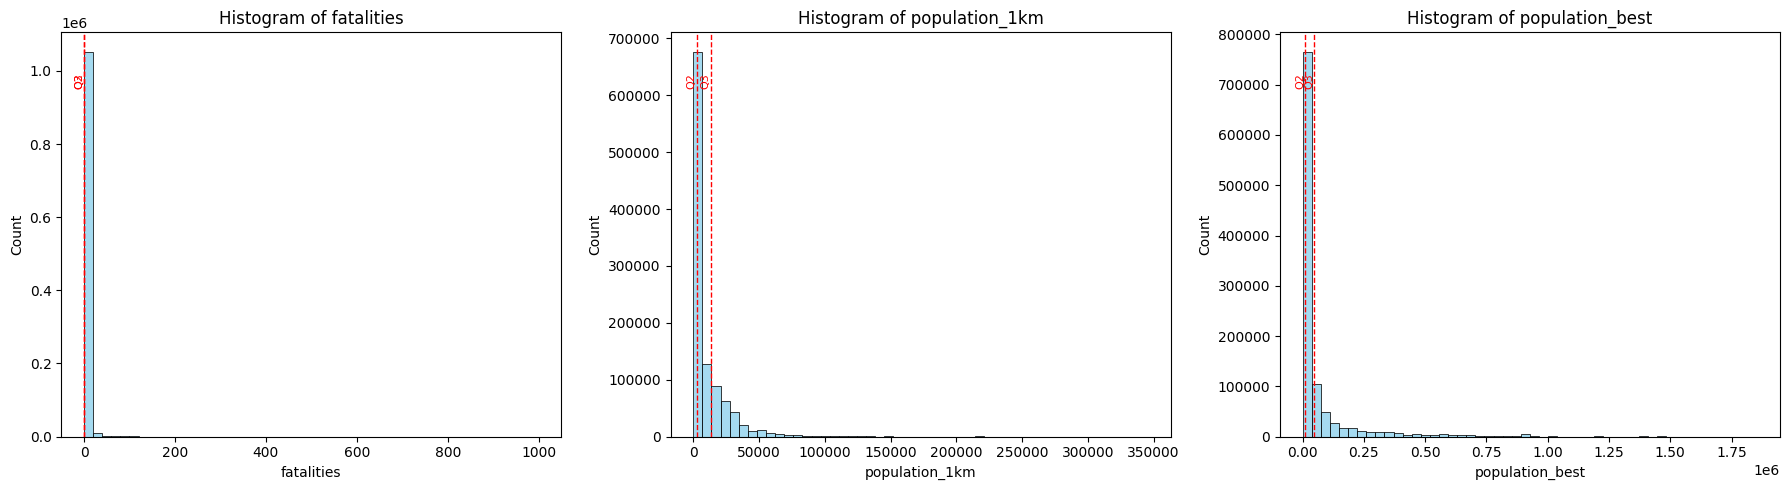

In [93]:
# visualize distributions and quartiles to identify outliers

cols = ["fatalities", "population_1km", "population_best"]

# create figure
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, col in zip(axes, cols):
    data = df[col].dropna()

    # create histogram
    sns.histplot(data, bins=50, kde=False, ax=ax, color="skyblue")
    # calculate quartiles
    q2 = np.percentile(data, 50)
    q3 = np.percentile(data, 75)
    # draw lines for Q2 and Q3
    for q, label in zip([q2, q3], ["Q2", "Q3"]):
        ax.axvline(q, color="red", linestyle="--", linewidth=1)
        ax.text(
            q, 
            ax.get_ylim()[1] * 0.9, 
            label, 
            rotation=90, 
            verticalalignment="top", 
            horizontalalignment="right",
            fontsize=8,
            color="red"
        )

    # add titles and labels
    ax.set_title(f"Histogram of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

<ins>**'fatalities'**</ins> as shown in the EDA, there is a heavy tail here, which implicitly means outliers. However, it is exactly this tail, i.e. the outliers, that we want model. Will NOT remove the outliers.

<ins>**'population_1km' & 'population_best'**</ins> both have a exponential distribution and likely many outliers. However, this is normal for population distributions. ACLED's quality is considered high and, unlike 'fatalities', population density measurements come from reputable sources. No reason to believe that there would be erroneous outliers - all outliers represent legitimate demographics and will NOT be removed.


In [94]:
# save cleaned dataset
df.to_csv(Path.cwd().parent / 'data/clean/acled_clean.csv', index=False)

# Feature Engineering

DBSCAN will be used to cluster the conflicts (see explanation in notebook 03_modelling). This algorithm has the following requirements:

1. Reduced dimensionality - cannot handle a high amount of predictor variables
2. Categorical data is encoded
3. No extreme magnitudes - as the algorithm is based on Euclidean distance, large values would dominate. As such:
    - Convert to logarithmic scale - this reduces the skewness: compresses the tail whilst preserving relative distances. BUT does not affect scale.
    - Rescale using Z-score normalisation - assures that all numericals contribute equally to DBSCAN's distance calculations.
4. Remove artificial clusters: events with 'geo_precision' = 3 have inaccurate coordinates based on centroids (see notebook 01_eda). Will remove. 

In [95]:
print(df['source_scale'].unique().tolist())

['National', 'International', 'Other', 'Local/Subnational', 'Regional', 'New media', nan]


In [96]:
# create copy for feature engineering
df_input = df.copy()
# set index to event_id_cnty for easier referencing after one-hot encoding
df_input = df_input.set_index("event_id_cnty")

In [97]:
# as DBSCAN cannot handle high dimensionality, "country" and "sub_event_type" will be dropped
df_input.drop(columns=['country', 'sub_event_type'], inplace=True)

In [98]:
# drop rows with geo_precision == 3 (low precision)
df_input.drop(df_input[df_input['geo_precision'] == 3].index, axis=0, inplace=True)

# drop column 'geo_precision' as it is not useful on its own
df_input.drop(columns=['geo_precision'], inplace=True)

In [99]:
# select categorical columns for one-hot encoding
categorical_cols = ["region", "event_type", "interaction", "source_scale"]
# encode using one-hot encoding, ensure dummies are of integer type
df_dummies = pd.get_dummies(df_input[categorical_cols], drop_first=False).astype(int)

In [100]:
# rescale the numerical columns to logarithmic scale to reduce the impact of outliers
df_input["fatalities_log"] = np.log1p(df_input["fatalities"])
df_input["pop1_log"] = np.log1p(df_input["population_1km"])
df_input["popbest_log"] = np.log1p(df_input["population_best"])

# drop the original columns
df_input.drop(columns=['fatalities', 'population_1km', 'population_best'], inplace=True)

In [101]:
# rescale all numericals using StandardScaler
numeric_cols = ["latitude", "longitude", "fatalities_log", "pop1_log", "popbest_log"]

# create and apply StandardScaler
scaler = StandardScaler()
numeric_scaled = scaler.fit_transform(df_input[numeric_cols])

# Convert back to DataFrame for clarity
numeric_scaled = pd.DataFrame(numeric_scaled, columns=numeric_cols, index=df_input.index)

In [102]:
# combine numerical and categorical features into final feature set X
X = pd.concat([numeric_scaled, df_dummies], axis=1)

In [103]:
X.head()

,latitude,longitude,fatalities_log,pop1_log,popbest_log,region_Caribbean,region_Caucasus and Central Asia,region_Central America,region_East Asia,region_Eastern Africa,...,interaction_State forces-Identity militia,interaction_State forces-Political militia,interaction_State forces-Rebel group,interaction_State forces-State forces,source_scale_International,source_scale_Local/Subnational,source_scale_National,source_scale_New media,source_scale_Other,source_scale_Regional
event_id_cnty,,,,,,,,,,,,,,,,,,,,,
MMR1,-0.468005,1.474723,-0.635625,0.204034,0.032117,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
SOM5580,-1.206010,0.372789,2.174700,0.843064,0.508404,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
BGD7238,-0.017503,1.301178,-0.635625,0.774235,0.947187,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
ETH1319,-0.549987,0.264585,2.605084,0.436805,0.473836,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
ETH1320,-0.549302,0.263375,2.605084,0.436805,0.473836,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [104]:
# save feature set
X.to_csv(Path.cwd().parent / 'data/final/dbscan_input.csv', index=True)